<a href="https://colab.research.google.com/github/flora0110/spotify_segment_headine/blob/main/textsplit_history_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install word2vec

     |████████████████████████████████| 42 kB 823 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=15258ced2abe60e67dad47b6e8a81559129d8621612a1a26c85920d9534309be
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [ ]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [ ]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

links = {'history': 'https://raw.githubusercontent.com/flora0110/spotify_segment_headine/main/podcast_data/history_comma.txt',  # a tale of two cities
         'siddartha': 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-03-17 17:12:52--  https://raw.githubusercontent.com/flora0110/spotify_segment_headine/main/podcast_data/history_comma.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28069 (27K) [text/plain]
Saving to: ‘history_comma.txt’

history_comma.txt   100%[===================>]  27.41K  --.-KB/s    in 0.003s  

2022-03-17 17:12:52 (9.20 MB/s) - ‘history_comma.txt’ saved [28069/28069]



In [ ]:
corpus_path
with open('./text8','r',encoding='utf-8') as file:
    for line in file.readlines():
        print(len(line))

100000000


## Train wordvectors

In [ ]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)
  #word2vec.Word2Vec(corpus_path, wrdvec_path, cbow=1, iter_=5, hs=1, threads=8, sample='1e-5', window=15, size=200, binary=1)

In [ ]:
model.save(wrdvec_path)

In [ ]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)
# del model
print(wrdvecs.shape)

(71290, 200)


## get sentence tokenizer

In [ ]:
!pip install textsplit

In [ ]:
from textsplit.tools import SimpleSentenceTokenizer
#from nltk.tokenize import sent_tokenize
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [ ]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

penalty 43.98
489 sentences, 21 segments, avg 23.29 sentences per segment
optimal score 10027.61, greedy score 10000.71
ratio of scores 1.0027


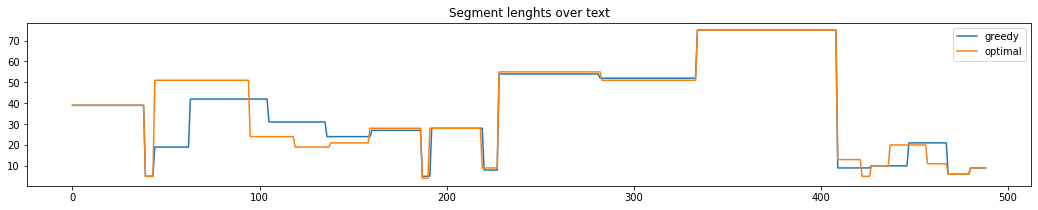

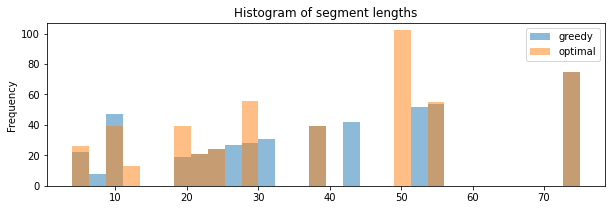

In [ ]:
# link = links['siddartha']
#import nltk
#nltk.download('punkt')
link = links['history']
segment_len = 30  # segment target length in sentences
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

#sentenced_text =sent_tokenize(text)
#for i in range(5):
#  print(sentenced_text)
sentenced_text = sentence_tokenizer(text)
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

## Evaluation

If you look into the written file `book_path`.seg, the snippet line is often at the boundary of a paragraph.  The word embeddings computed above are neither very good nor adapted to the text. Every unknown word has a zero vector. Choosing some more or less random vector for unknown words might improve the accuracy given those unknown terms appear repeatedly within a section.

In [ ]:
print(text)
print(optimal_segmentation)
#for i in range(5)
#print
for i in range(21):
  print(segmented_text[i])


Hi friends. Happy Wednesday or Thursday if you're watching over on YouTube. Hey, how are you doing? I hope you're having a wonderful day so far. My name is Bailey serían and this is the dark History Podcast. Whew, I need a theme song for dark history. Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. I never learned in school. If you're new here. Hi, welcome. Come. Take a seat by me. Don't be shy if you're And learning about people and events that your history books didn't cover in school. The maybe should have then you'll fit in right in here with us. Okay. Look today's story. It's uncomfortable. Okay, it's heartbreaking. It's just, it's set. It's awful. It's sad. There's, those are all the words. I can think of it, just doesn't make any sense. But with all of that being said, there's really like no sugarcoating this. This is what happened. And it's when more honest and when we're transparent that we can lea